# Running HMETS using NRCAN forcing data

Here we use birdy's WPS client to launch the HMETS hydrological model on the server and analyze the output. We also prepare NRCAN daily data for Canadian catchments.

In [1]:
from birdy import WPSClient

from example_data import TESTDATA
import datetime as dt
from pathlib import Path
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import netCDF4 as nc
import salem
from zipfile import ZipFile
import glob
import tempfile

# Set environment variable RAVEN_WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get("RAVEN_WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")
wps = WPSClient(url)

In [2]:
# SETUP THE RUN PARAMETERS, for now only the start and end years of the simulation, the rest is hard-coded to 
# the Salmon-river example

start = dt.datetime(2007, 1, 1)
stop = dt.datetime(2008, 1, 1)


# The shapefile of the catchment to model using ERA5 data. All files (.shp, .shx, etc.) must be zipped into one file.
vec = TESTDATA["watershed_vector"]

In [3]:
# DATA MAIN SOURCE - DAP link
CANOPEX_DAP = 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ets/Watersheds_5797_cfcompliant.nc'
CANOPEX_URL = 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/fileServer/birdhouse/ets/Watersheds_5797_cfcompliant.nc'
ds = xr.open_dataset(CANOPEX_DAP)


In [4]:
# Specify the watershed outlet (here in this example this is the Salmon River)
lon, lat = -123.3659, 54.4848

# For now, we have no mechanism to link a location (lon, lat) to a given watershed. Let's pick one at random: 
wid = 5600
print(ds.watershed[wid].data)

# With a watershed contour, we'll be able to get the elevation. 

area = ds.drainage_area.isel(watershed=wid).data
print("Area: ", area)
elevation = 350  # Random value

b'WHITEMOUTH RIVER NEAR WHITEMOUTH'
Area:  3750.0


In [5]:
# Ideally we would be able to pass the DAP link directly to Raven, but there are still some issues 
# to fix to be able to do that. For now, we'll download the series at the point of interest. 
path = Path(tempfile.mkdtemp()) /  "ts.nc"
ts = ds.isel(watershed=wid).sel(time=slice(start, stop))
ts.to_netcdf(path)

# Add precision on time format for Raven
D = nc.Dataset(path, mode="a")
D.variables["time"].units += " 00:00:00"
D.close()

In [6]:
import json
# The model parameters. Can either be a string of comma separated values, a list, an array or a named tuple. 
params = '9.5019, 0.2774, 6.3942, 0.6884, 1.2875, 5.4134, 2.3641, 0.0973, 0.0464, 0.1998, 0.0222, -1.0919, ' \
            '     2.6851, 0.3740, 1.0000, 0.4739, 0.0114, 0.0243, 0.0069, 310.7211, 916.1947'

# Model configuration parameters
config = dict(
    start_date=start,
    end_date=stop,
    area=area,
    elevation=elevation,
    latitude=lat,
    longitude=lon,
    run_name='test_hmets_NRCAN',
    rain_snow_fraction='RAINSNOW_DINGMAN', 
    nc_spec=json.dumps({'tasmax': {'linear_transform': (1.0, -273.15)},'tasmin': {'linear_transform': (1.0, -273.15)},'pr': {'linear_transform': (86400.0, 0.0)}},),
    nc_index=wid,  #This is where we set the watershed index.
)

# Let's call the model with the timeseries, model parameters and other configuration parameters
resp = wps.raven_hmets(ts=str(path), params=params, **config)


In [7]:
# And get the response
# With `asobj` set to False, only the reference to the output is returned in the response. 
# Setting `asobj` to True will retrieve the actual files and copy the locally. 
[hydrograph, storage, solution, diagnostics, rv] = resp.get(asobj=True)

Since we requested output objects, we can simply access the output objects. The dianostics is just a CSV file: 

In [8]:
print(diagnostics)

observed data series,filename,DIAG_NASH_SUTCLIFFE,DIAG_RMSE,
HYDROGRAPH,/tmp/pywps_process_fwlve1jd/ts.nc,-14.0427,93.9115,



The `hydrograph` and `storage` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools. 

In [9]:
hydrograph.q_sim

<xarray.DataArray 'q_sim' (time: 366, nbasins: 1)>
array([[  0.      ],
       [150.782482],
       [298.437317],
       ...,
       [ 27.021254],
       [ 26.662489],
       [ 26.28611 ]])
Coordinates:
  * time        (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2008-01-01
    basin_name  (nbasins) object ...
Dimensions without coordinates: nbasins
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows

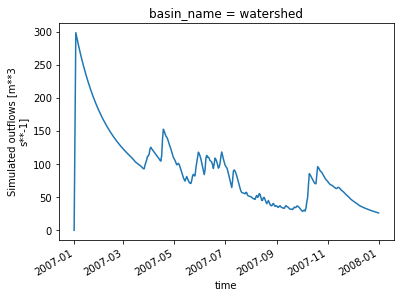

In [10]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

hydrograph.q_sim.plot()

In [11]:
print("Max: ", hydrograph.q_sim.max())
print("Mean: ", hydrograph.q_sim.mean())
print("Monthly means: ", hydrograph.q_sim.groupby(hydrograph.time.dt.month).mean(dim='time'))

Max:  <xarray.DataArray 'q_sim' ()>
array(298.43731743)
Mean:  <xarray.DataArray 'q_sim' ()>
array(91.78560094)
Monthly means:  <xarray.DataArray 'q_sim' (month: 12, nbasins: 1)>
array([[215.23703926],
       [147.83557474],
       [106.69359271],
       [123.51496075],
       [ 89.51759258],
       [103.43311781],
       [ 71.39185792],
       [ 45.34091337],
       [ 34.43253178],
       [ 69.25228946],
       [ 60.57374341],
       [ 34.18820503]])
Coordinates:
    basin_name  (nbasins) object 'watershed'
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nbasins
